In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Up Import Libraries

In [3]:
# Install any missing libraries
!pip install -q scikit-learn pandas matplotlib


# Import Libraries and Define Helper Functions

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load and Preprocess the Data

In [5]:
# Define paths and parameters
# Update this path to your actual path to the mango leaf dataset within your Google Drive
data_dir = '/content/drive/MyDrive/CSE475/Lab 01 Task/MangoLeafBD Dataset'
img_size = (320, 320)

# Preprocess images and labels
def load_images_and_labels(data_dir, img_size):
    labels = []
    images = []

# Check if the directory exists
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory not found: {data_dir}")

    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                img = cv2.imread(img_path)

                # Check if the image was loaded successfully
                if img is None:
                    print(f"Warning: Failed to load image: {img_path}")
                    continue  # Skip this image and continue with the next one

                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(category)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load the images and labels
images, labels = load_images_and_labels(data_dir, img_size)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Prepare the Data for Training

In [6]:
# Flatten images
X = images.reshape(images.shape[0], -1)
y = labels

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate the Decision Tree and Random Forest Classifiers

Decision Tree Classifier

In [7]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Initialize, train and predict for the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test) # Make prediction and store in y_pred_dt

# Calculate accuracy and other metrics for Decision Tree (optional but recommended)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Classifier Accuracy:", dt_accuracy)
print("Classification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))

Decision Tree Classifier Accuracy: 0.7
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.68      0.68      0.68        90
           1       0.81      0.79      0.80       112
           2       0.87      0.99      0.93        91
           3       0.90      0.87      0.88       104
           4       0.49      0.45      0.47       101
           5       0.67      0.68      0.67        93
           6       0.55      0.66      0.60        86
           7       0.60      0.54      0.57       123

    accuracy                           0.70       800
   macro avg       0.70      0.71      0.70       800
weighted avg       0.70      0.70      0.70       800



Random Forest Classifier

In [8]:
# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Random Forest Classifier Accuracy: 0.89
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        90
           1       0.86      0.90      0.88       112
           2       0.98      1.00      0.99        91
           3       1.00      0.92      0.96       104
           4       0.80      0.80      0.80       101
           5       0.88      0.95      0.91        93
           6       0.87      0.85      0.86        86
           7       0.84      0.81      0.83       123

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



# Visualize Results

In [9]:
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

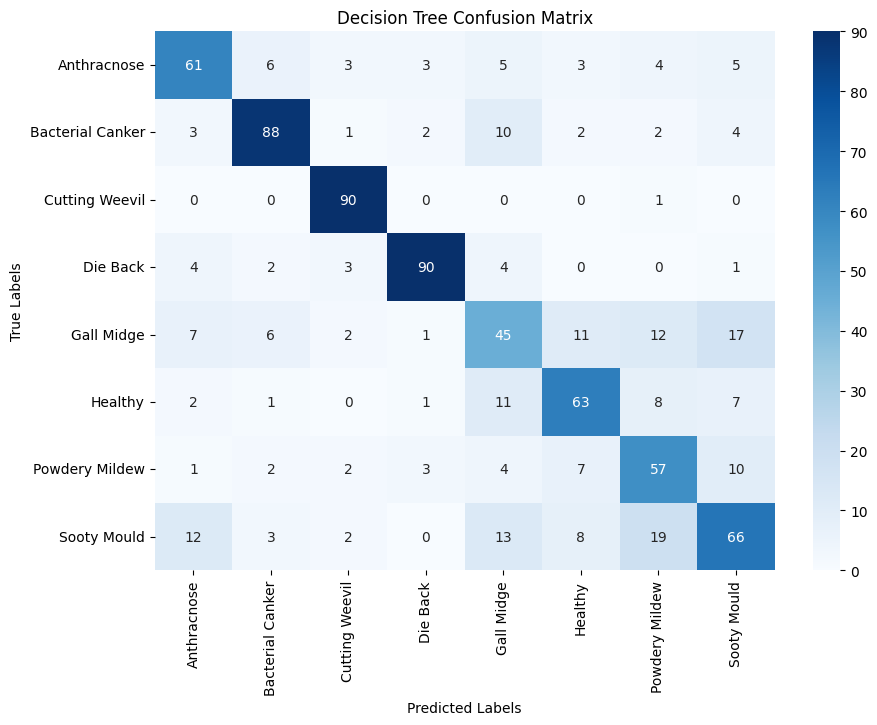

In [10]:
# Plot confusion matrix for Decision Tree
plot_confusion_matrix(confusion_matrix(y_test, y_pred_dt), le.classes_, "Decision Tree Confusion Matrix")


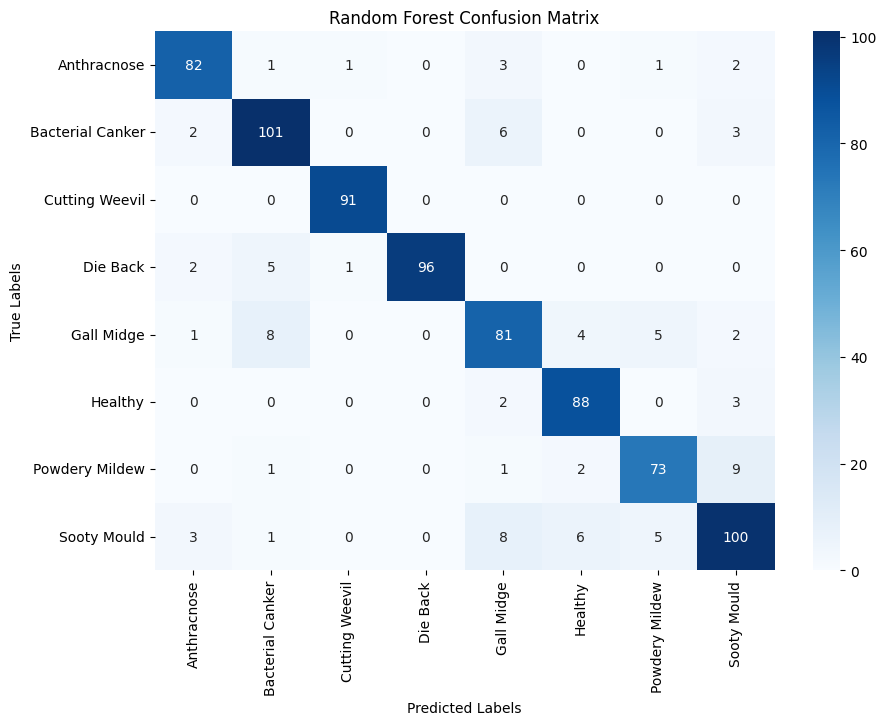

In [11]:

# Plot confusion matrix for Random Forest
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rf), le.classes_, "Random Forest Confusion Matrix")

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay

In [13]:
# Binarize the labels for ROC curve (One-vs-Rest)
y_train_bin = label_binarize(y_train, classes=np.unique(y))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_train_bin.shape[1]

# Initialize OneVsRestClassifier wrappers for both classifiers
ovr_dt_classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
ovr_rf_classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))


In [ ]:
# Train classifiers on the binarized labels for multiclass ROC
ovr_dt_classifier.fit(X_train, y_train_bin)
ovr_rf_classifier.fit(X_train, y_train_bin)

In [ ]:
# Predict probabilities
y_score_dt = ovr_dt_classifier.predict_proba(X_test)
y_score_rf = ovr_rf_classifier.predict_proba(X_test)


In [ ]:
# Plot ROC curves for each classifier
def plot_roc_curve(y_test_bin, y_score, n_classes, classifier_name):
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Plot ROC curves
plot_roc_curve(y_test_bin, y_score_dt, n_classes, "Decision Tree")

In [ ]:
# Plot ROC curves
plot_roc_curve(y_test_bin, y_score_rf, n_classes, "Random Forest")

In [ ]:
# Learning Curve Function
def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 7))
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.2)

    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
# Plot learning curves
plot_learning_curve(dt_classifier, "Decision Tree Learning Curve", X, y)

In [ ]:
# Plot learning curves
plot_learning_curve(rf_classifier, "Random Forest Learning Curve", X, y)